In [1]:
notebook_id = "151"

<a id="ID_top"></a>
## Adjacency matrix and network chart

This workflow takes live files and calls on functions in `script_adj_matrix_plot.py` to create adjancency matrices and network graph

#### Notebook sections:
    
|| [0|Top](#ID_top) || [1|Part1](#ID_part1) || [2|Part2](#ID_part2) || [3|Part3](#ID_part3) || [4|Part4](#ID_part4) || [5|Part5](#ID_part5) ||

### Packages

In [2]:
# %load s_package_import
# package library, use to ensure consistency across notebooks, refresh periodically
# general packages
import os # use with os.listdir(_path_)
import requests
import csv
import time
from datetime import datetime
from shutil import copyfile

#temp check
#from shutil import make_archive
import zipfile

# data analysis packages
import pandas as pd
pd.options.display.max_columns = None # don't truncate columns
#pd.options.display.max_rows = None

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
import pycountry

# custom scripts
import s_file_export
import s_filepaths
import s_un_comtrade_extract as s_un
import s_adj_matrix_plot

#=== network analysis
import networkx as nx
#=== gavity modelling
import gme as gme

#### Import module and declare path variables
`import s_filepaths.py`

In [3]:
# import ref file
import s_filepaths

# declare local variables to work with
path_raw = s_filepaths.path_raw
path_raw_dl = s_filepaths.path_raw_dl
path_store = s_filepaths.path_store
path_live = s_filepaths.path_live
path_image = s_filepaths.path_images

<a id="ID_part2"></a>
### Part 2 | Load files
|| [0|Top](#ID_top) || [1|Part1](#ID_part1) || [2|Part2](#ID_part2) || [3|Part3](#ID_part3) || [4|Part4](#ID_part4) || [5|Part5](#ID_part5) ||

In [4]:
# list of all files
filenames = os.listdir(path_live)
print(filenames)

# list of file names that can be read with same rule
file_to_batch_read = "input_gme_data_joined.csv.gzip"

['input_101_master_country_table.csv.csv.gzip', 'input_test.csv.gzip', 'input_un_com_2013.csv.gzip', 'input_un_com_2012.csv.gzip', 'input_un_com_2006-2009.csv.gzip', '.DS_Store', 'input_101_master_country_table.csv.gzip', 'input_un_codes_ref.csv.gzip', 'input_bri_countries_manual_2020.csv.gzip', 'input_un_com_2016-2019.csv.gzip', 'input_un_com_2002-2005.csv.gzip', 'input_un_com_2014.csv.gzip', 'input_un_com_2015.csv.gzip', 'input_bri_countries_Dumor_Yao.csv.gzip', '2_raw_explainer_doc.md', 'input_dynamic_gravity.csv.gzip', 'input_un_com_2010_merged_ref.csv.gzip', 'input_gme_data_joined.csv.gzip', 'input_un_sample.csv.gzip']


Load data directly from compressed file to avoid GitHub issues with storage

In [5]:
# Load data
network_df_raw = pd.read_csv(f"{path_live}{file_to_batch_read}",compression= "gzip")
network_df_raw.head()

,year,country_o,iso3_o,country_d,iso3_d,distance,gdp_wdi_const_o,gdp_wdi_const_d,common_language,contiguity,agree_pta_goods,agree_cu,sanction_imposition,rtCode,rt3ISO,rtTitle,ptCode,pt3ISO,ptTitle,period,rgDesc,yr,rgCode,cmdCode,TradeValue,periodDesc,pfCode,cmdDescE
0,2009,Philippines,PHL,Aruba,ABW,16904.5960,1.854377e+11,NaN,1,0,0,0,0.0,608,PHL,Philippines,533,ABW,Aruba,2009,Import,2009,1,TOTAL,72162,2009,H2,ALL COMMODITIES
1,2009,Philippines,PHL,Aruba,ABW,16904.5960,1.854377e+11,NaN,1,0,0,0,0.0,608,PHL,Philippines,533,ABW,Aruba,2009,Export,2009,2,TOTAL,149587,2009,H2,ALL COMMODITIES
2,2009,Romania,ROU,Afghanistan,AFG,1883.9504,1.693503e+11,1.469733e+10,0,0,0,0,0.0,642,ROU,Romania,4,AFG,Afghanistan,2009,Import,2009,1,TOTAL,1688,2009,H3,All Commodities
3,2009,Romania,ROU,Afghanistan,AFG,1883.9504,1.693503e+11,1.469733e+10,0,0,0,0,0.0,642,ROU,Romania,4,AFG,Afghanistan,2009,Export,2009,2,TOTAL,15843818,2009,H3,All Commodities
4,2010,Denmark,DNK,Afghanistan,AFG,4835.0132,3.219939e+11,1.593680e+10,0,0,0,0,0.0,208,DNK,Denmark,4,AFG,Afghanistan,2010,Import,2010,1,TOTAL,5267969,2010,H3,All Commodities


### Prepare data for visualisation

In [6]:
# only neighbouring countries

#network_df_vis = network_df_raw[network_df_raw.year == 2016]
network_df_vis = network_df_raw.copy()
network_df_vis = network_df_vis[(network_df_vis.contiguity == 1) & (network_df_vis.year == 2010) & (network_df_vis.rgDesc == "Export")]
#network_df_vis = network_df_vis[(network_df_vis.contiguity == 1)]

network_df_vis.head()

,year,country_o,iso3_o,country_d,iso3_d,distance,gdp_wdi_const_o,gdp_wdi_const_d,common_language,contiguity,agree_pta_goods,agree_cu,sanction_imposition,rtCode,rt3ISO,rtTitle,ptCode,pt3ISO,ptTitle,period,rgDesc,yr,rgCode,cmdCode,TradeValue,periodDesc,pfCode,cmdDescE
486,2010,Slovenia,SVN,Hungary,HUN,370.63492,4.801647e+10,1.302582e+11,1,1,1,1,0.0,705,SVN,Slovenia,348,HUN,Hungary,2010,Export,2010,2,TOTAL,719092694,2010,H3,All Commodities
603,2010,Israel,ISR,Lebanon,LBN,211.13699,2.337547e+11,3.800995e+10,1,1,0,0,0.0,376,ISR,Israel,422,LBN,Lebanon,2010,Export,2010,2,TOTAL,3000,2010,H3,All Commodities
2824,2010,Pakistan,PAK,Afghanistan,AFG,774.05566,1.774069e+11,1.593680e+10,1,1,0,0,0.0,586,PAK,Pakistan,4,AFG,Afghanistan,2010,Export,2010,2,TOTAL,1684665983,2010,H3,All Commodities
2839,2010,China,CHN,Afghanistan,AFG,4353.06490,6.100620e+12,1.593680e+10,0,1,0,0,0.0,156,CHN,China,4,AFG,Afghanistan,2010,Export,2010,2,TOTAL,175264609,2010,H3,All Commodities
2960,2010,Iran,IRN,Afghanistan,AFG,1495.72110,4.677902e+11,1.593680e+10,1,1,0,0,0.0,364,IRN,Iran,4,AFG,Afghanistan,2010,Export,2010,2,TOTAL,1315721611,2010,H2,ALL COMMODITIES


In [7]:
#temp_df test df working
test_f_run = s_adj_matrix_plot.f_adj_matrix(network_df_vis,"iso3_o","iso3_d",p_col_full = "country_o",p_index_full = "country_d")


Start-up report | Two different unequal count (col: 76 index: 110) columns are used.


nodes: 113
edges: 206


/Users/antonios/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


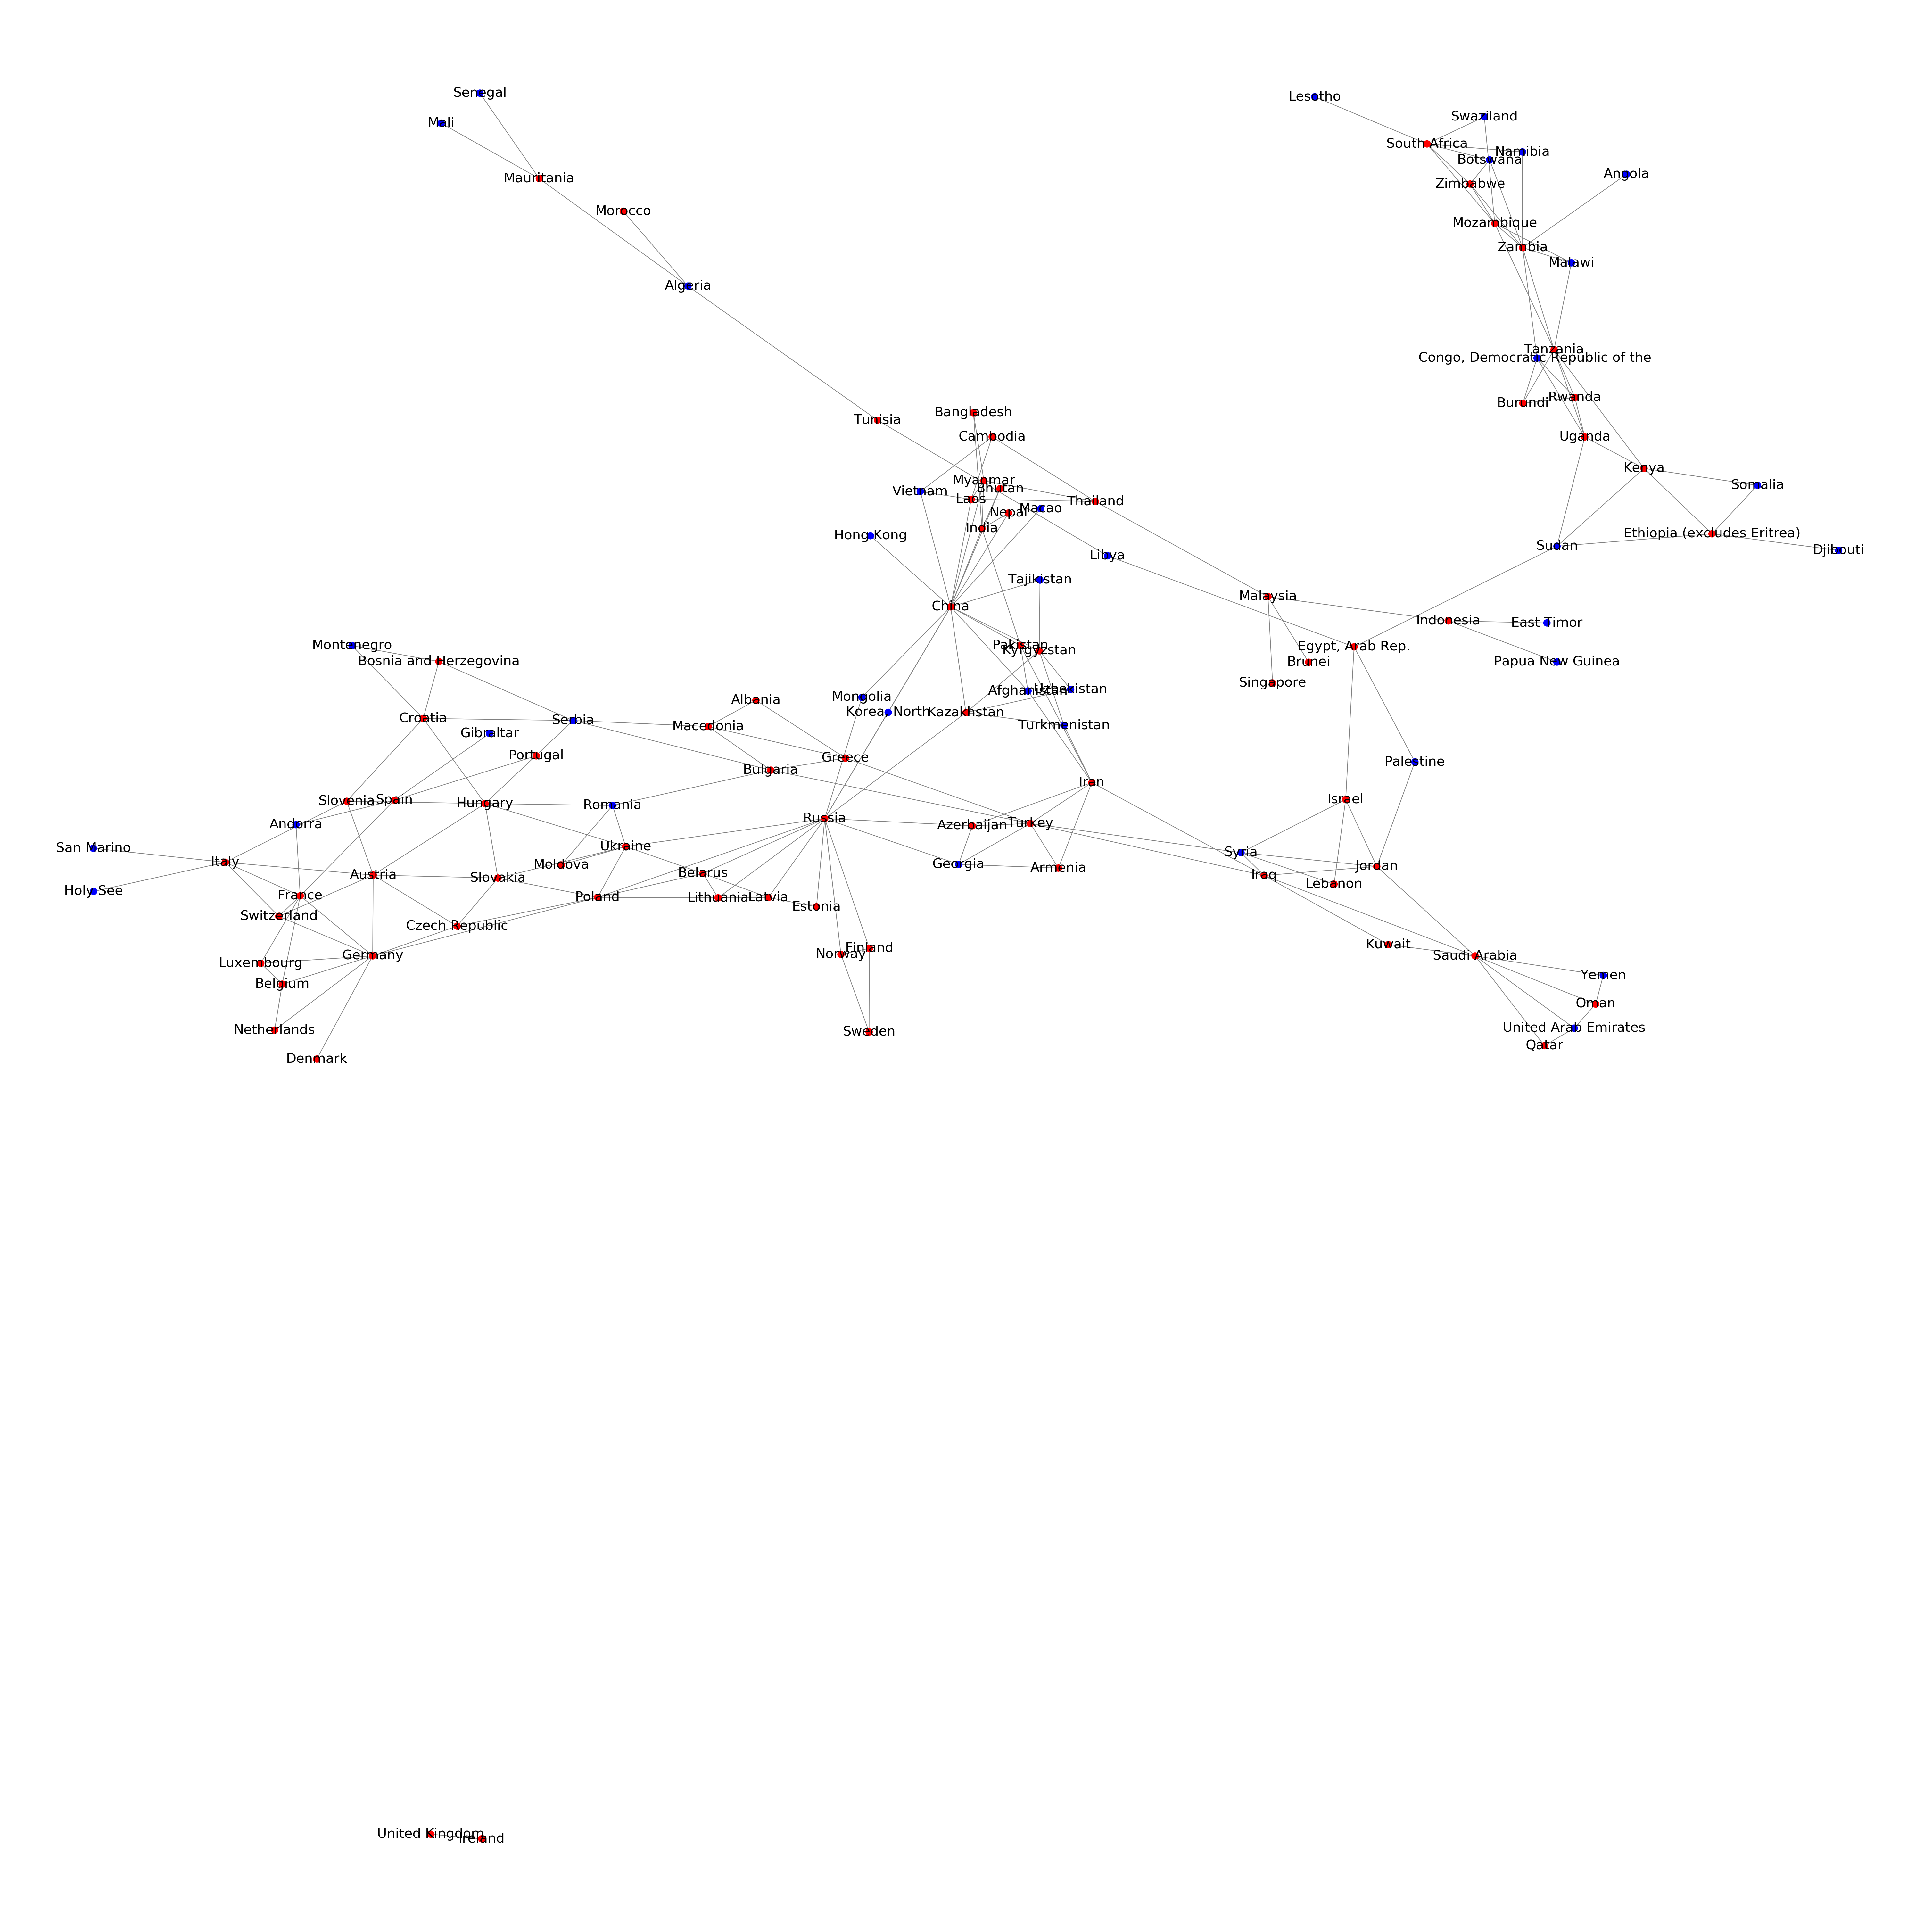

In [8]:
graph_object = s_adj_matrix_plot.f_graph(test_f_run[1],p_group_of_countries = list(network_df_vis.country_o.unique()),
                          p_edge_colour="grey",p_colour_group="red",p_seed = 1, p_weight = "distance"                     
                         )

In [ ]:
plt.figure(1,figsize = (40,40),dpi = 150)
nx.spectral_layout(graph_object,edge_color = "grey",
               node_size=100,font_size=20,seed = 1,weight="distance")#,with_labels = True, font_weight = "light")
plt.show()

In [ ]:
plt.figure(1,figsize = (40,40),dpi = 150)

pos = nx.draw_kamada_kawai(graph_object, weight = "distance")
nx.draw(graph_object,pos = pos)#,with_labels = True, font_weight = "light")
plt.show()

In [ ]:
break

In [ ]:
def f_graph(p_tuples,p_group_of_countries = None,p_colour_group = "yellow", p_colour_default = "blue", p_edge_colour = "red"):

    """This function takes in the list of tuples from f_adj_matrix() (should be at index [1])
    Plus list of countries (full name, i.e. country_o or country_d columns) for colournig, else defaults to blue nodes"""
    import networkx as nx

    #=== Set up network
    f_G = nx.Graph()

    # Add nodes based on full country names
    #f_G.add_nodes_from(p_uniques)

    #=== base for checking nodes and edges
    def f_add_node_and_edge(p_graph,p_central_node,p_node_list,p_length = 5):
        # list of edges
        temp_edges = []
        # list of neighbours
        p_node_list

        try:
            p_graph.add_node(p_central_node)
        except:
            pass

        for country in p_node_list:
            temp_tuple = (p_central_node,country)
            temp_edges.append(temp_tuple)

        p_graph.add_edges_from(temp_edges,length = p_length)

    #=== run function to add values
    for entry in p_tuples:
        f_add_node_and_edge(f_G,entry[0],entry[1])

    #=== node colouring | compare list of countries to be treated differently to list of nodes
    colour_list = []


    for entry in list(f_G.nodes):
        if entry in p_group_of_countries:
            colour_list.append(p_colour_group)
        else:
            colour_list.append(p_colour_default)
    #except:
     #   print("Colouring didn't work, defaulting to {p_col_default}")
      #  colour_list = p_colour_default

    #=== report
    print("nodes:",f_G.number_of_nodes())
    print("edges:",f_G.number_of_edges())


In [ ]:
f_G_out = f_graph(test_f_run[1],p_group_of_countries = list(network_df_vis.country_o.unique()))

In [ ]:
len(test_f_run[1])

In [ ]:
break

#### Filter on certain countries

Filter for all of asia:
```
trial_df = trial_df[
    ((trial_df.region_d.str.contains("asia")) | (trial_df.region_d.str.contains("east")))
    & 
    ((trial_df.region_o.str.contains("asia")) | (trial_df.region_o.str.contains("east")))
```

Filter for all countries that have a connection (avoid showing little islands or unconnected regions
```
trial_df = trial_df[(trial_df.contiguity == 1)]
```

In [ ]:
# Filters
europe_filter = (trial_df.region_d == "europe") & (trial_df.region_o == "europe")
europe_land_filter = (trial_df.region_d == "europe") & (trial_df.region_o == "europe") & (trial_df.contiguity == 1)
asia_all = ((trial_df.region_d.str.contains("asia")) | (trial_df.region_d.str.contains("east"))) & ((trial_df.region_o.str.contains("asia")) | (trial_df.region_o.str.contains("east")))
land_all = (trial_df.contiguity == 1)

#trial_df = trial_df[(trial_df.region_d == "europe") & (trial_df.region_o == "europe") & (trial_df.contiguity == 1)]

In [ ]:
# Preview data
trial_df = df_05_16[df_05_16.year == 2016]
trial_df = trial_df[(trial_df.region_d == "europe") & (trial_df.region_o == "europe") & (trial_df.contiguity == 1)]

trial_df.head()

<a id="ID_part3"></a>
### Part 3 | Produce matrix and network
|| [0|Top](#ID_top) || [1|Part1](#ID_part1) || [2|Part2](#ID_part2) || [3|Part3](#ID_part3) || [4|Part4](#ID_part4) || [5|Part5](#ID_part5) ||

In [ ]:
#temp_df test df working
test_f_run = mp.f_adj_matrix(trial_df,"iso3_o","iso3_d",p_col_full = "country_o",p_index_full = "country_d")
mp.f_graph(test_f_run[1])